In [1]:
%matplotlib inline

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
# import contractions
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

In [5]:
tf.__version__

'1.8.0'

# Introduction

This notebook is intended to be a tutorial providing a walk-through and explanation of the steps required to build a variable length sequential input recurrent model in TensorFlow.  The tutorial covers:

* Minimal text preprocessing
* Word contraction replacement + tokenization
* Using word embeddings
* TensorFlow’s Dataset API for batching and loading data
* Efficient handling of variable length input

The dataset used in the tutorial consists of Yelp restaurant reviews which are:
* Polarized (1 or 2 stars = negative; 5 stars = positive)
* 400 to 500 characters per review

All steps followed for preprocessing the dataset used in this tutorial can be found in the notebook at:  
https://github.com/kunal-kotian/deep_learning_sentiment_classification/blob/master/filter/filtering_reviews.ipynb

Running the notebook at the link above will help you generate the file `reviews_labeled.feather` used below.

# Prepare Input Data

In [ ]:
reviews_labeled = pd.read_feather('../data/reviews_labeled.feather')

In [19]:
reviews_labeled.shape

(136002, 2)

Note that we have an equal number of positive and negative labeled reviews:

In [37]:
reviews_labeled.is_positive.value_counts()

1    68001
0    68001
Name: is_positive, dtype: int64

In [20]:
reviews_labeled.iloc[0]        # sample record

text           This is nothing like Chipotle, the food taste ...
is_positive                                                    1
Name: 0, dtype: object

In [21]:
reviews_labeled.text.iloc[0]   # sample review text

"This is nothing like Chipotle, the food taste way better, the quality of the food is great. This is the perfect example of eating in a moms pops restaurant. The atmosphere is awesome, the service is great. If you are looking for good Mexican food this is the place to go, you will not be disappointed. I would go out of my way to eat here that's for sure. I ordered the veggie bowl, since I am vegetarian, best bowl ever. It last me two days."

We need to break down the text from reviews from its present form, which is a string, to an ordered list of words.  These words are 'features' of each review, and must later be converted into a numerical representation that the neural network can work with.

## Replace Contractions

This can be considered to be an optional step.  This replaces common word contractions - e.g. `doesn't` is replaced by `does not`.  We use a module called `contractions` (easily installed via `pip install contractions`) that maintains a list of common English contractions and their corresponding expanded versions.

Here's a sample usage of the `contractions` module:


In [24]:
sentence = "He doesn't know how they've done the job.  I won't allow it."
print('Original sentence: ', sentence)
print('Fixed sentence:    ', contractions.fix(sentence))

Original sentence:  He doesn't know how they've done the job.  I won't allow it.
Fixed sentence:     He does not know how they have done the job.  I will not allow it.


In [22]:
# create a new column with text that has contractions expanded
reviews_labeled['text_fixed'] = reviews_labeled.text.apply(contractions.fix)

Here's a sample comparison between an original review and the version with no contractions.  Words like `don't`, `couldn't`, `I've` have been expanded to their full forms.

In [38]:
reviews_labeled.text.iloc[3]

"I don't normally give five stars unless everything was PERFECT, but I truly couldn't find a single thing to complain about! Service was great, burgers were huge and one of the best I've ever had! $14.95 for a gigantic burger and fries in LV is very affordable! To start, they brought out a big ol' biscuit with honey butter sauce on top that was incredible!! Not long after, our burgers came out. Water was always full, we sat down right away, and it was air conditioned!! Definitely recommend!!"

In [39]:
reviews_labeled.text_fixed.iloc[3]

"I do not normally give five stars unless everything was PERFECT, but I truly could not find a single thing to complain about! Service was great, burgers we are huge and one of the best I have ever had! $14.95 for a gigantic burger and fries in LV is very affordable! To start, they brought out a big ol' biscuit with honey butter sauce on top that was incredible!! Not long after, our burgers came out. Water was always full, we sat down right away, and it was air conditioned!! Definitely recommend!!"

In [46]:
# drop original text column and rename text_fixed to text
reviews_labeled.drop(['text'], axis=1, inplace=True)
reviews_labeled.rename(columns={'text_fixed': 'text'}, inplace=True)

In [ ]:
# reviews_labeled.to_feather('../data/reviews_labeled_no_contractions.feather')
reviews_labeled = pd.read_feather('../data/reviews_labeled_no_contractions.feather')

In [5]:
reviews_labeled = pd.read_pickle('../data/reviews_labeled_no_contractions.pkl')

In [6]:
reviews_labeled.tail()

,is_positive,text
135997,0,This used to be one of the better places for a...
135998,0,Ridiculous place. I am shocked this chain stay...
135999,0,Do not waste your time nor your money here.. T...
136000,0,Hard to be the king of burgers if you do not h...
136001,0,Terrible and Slow Service. Declining Food Qual...


In [7]:
# randomly shuffle the dataframe
reviews_labeled = reviews_labeled.sample(frac=1).reset_index(drop=True)

In [8]:
reviews_labeled.tail()

,is_positive,text
135997,0,The food is ok but the service is questionnabl...
135998,1,"Delicious - all of the pasties are great, and ..."
135999,1,Oh my god the horchata latte is amazeballs!! A...
136000,0,Walked out bfore ordering!\nWent for a quiet d...
136001,0,Went last night for dinner with our son. Took ...


In [9]:
pd.to_pickle(reviews_labeled, '../data/reviews_labeled_no_contractions_shuffled.pkl')

In [6]:
reviews_labeled = pd.read_pickle('../data/reviews_labeled_no_contractions_shuffled.pkl')

In [7]:
reviews_labeled.shape

(136002, 2)

In [12]:
# sample subset for training
reviews_labeled = reviews_labeled.sample(frac=1).reset_index(drop=True)

In [13]:
reviews_labeled.shape

(136002, 2)

# Split Data into Training and Test Sets

At this point, we can perform an `80-20` split of the labeled dataset into training and test sets.  

In [47]:
train, test = train_test_split(reviews_labeled, test_size=0.2)

In [9]:
train.shape

(108801, 2)

In [10]:
test.shape

(27201, 2)

In [11]:
text_train = train.text.values.tolist()
sentiment_train = train.is_positive.values.reshape(len(train), 1)
# One-hot encode the target labels
onehot_encoder = OneHotEncoder(sparse=False)
sentiment_train = onehot_encoder.fit_transform(sentiment_train)
# del train   # uncomment this if running low on memory

In [12]:
text_test = test.text.values.tolist()
sentiment_test = test.is_positive.values.reshape(len(test), 1)
# One-hot encode the target labels
sentiment_test = onehot_encoder.transform(sentiment_test)
# del test   # uncomment this if running low on memory

# Tokenization

We use the built-in tokenizer from Keras to convert each review currently represented as a single text string, into a list of word tokens.

This blog provides a good explanation of the process:

http://www.developintelligence.com/blog/2017/06/practical-neural-networks-keras-classifying-yelp-reviews/

The crux is that Keras' tokenizer performs a 2-step process:

**Step 1**: Split text strings (reviews) into their constituent words. We specify the character to be used for splitting sentences; in this case, it will be the space character.

**Step 2**: Take all words split out from the sentences and rank them in the decreasing order of their counts.  So, the most common word will be ranked 1.

**Step 3**: Represent each word by its rank found in Step 2.  Here, we move from a string representation of each word to an integer representation.

Note that we also specify the maximum number of words we want to include in our vocabulary.  If we ask for our vocabulary size to be `n` words, then only the `n` most common words are included; the rest are removed from each reviw.


## Fitting and Transforming using the Tokenizer
The Keras tokenizer API performs two common preprocessing steps - lowercasing all words and removing punctuations - when it is fitted onto the training set.  Using the fitted tokenizer, we can convert any new text string into an equivalent list of tokens using the `texts_to_sequences` method.  Such a transformation of new text into tokens only uses the vocabulary known to the tokenizer.  Out-of-vocabulary words are ignored during the transformation of text to tokens.

**Important note:**

The `Tokenizer` starts assigning ids/indices to each word starting from `1`.  There is no word with id `0`.  This must be kept in mind when using the integer id for any word to index into a tensor/array of embeddings.

In [13]:
vocab_size = 10000    # the maximum size of our vocabulary
# import the built-in tokenizer from Keras
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, 
                                                  filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
                                                  lower=True, split=' ')

In [14]:
# fit tokenizer on reviews from the training set
tokenizer.fit_on_texts(text_train)
# convert text into sequences of integer tokens
text_train_intseq = tokenizer.texts_to_sequences(text_train)

In [15]:
# A sample showing the transformation of text_train into text_train_intseq
print('Text review: \n', text_train[0])
print('\nInteger sequence representation: \n', text_train_intseq[0])

Text review: 
 We saw good reviews about this restaurant on yelp. Made us decide to eat here before leaving for LA.

The dish I ordered was way too salty. I do not know why, but Thai restaurants in general season dishes too salty.
Anyway, I did not want to be in the car, being dehydrated for 4-5 hours on the way back to LA. So I asked our waiter to remake it. They remade it with just right amount of salt and it was good.

Integer sequence representation: 
 [8, 525, 28, 300, 67, 15, 65, 26, 431, 119, 66, 1441, 5, 105, 32, 148, 1026, 13, 685, 1, 282, 3, 56, 6, 132, 81, 596, 3, 46, 10, 147, 274, 21, 320, 299, 14, 1180, 2530, 263, 81, 596, 1102, 3, 55, 10, 152, 5, 30, 14, 1, 1126, 222, 8226, 13, 241, 144, 441, 26, 1, 132, 41, 5, 685, 27, 3, 178, 38, 298, 5, 3636, 9, 19, 4692, 9, 22, 40, 161, 542, 11, 820, 2, 9, 6, 28]


In [16]:
word2index = tokenizer.word_index

`word2index` is a dict mapping each word (string) to its unique index (rank) assigned by the tokenizer.  For example, the id/index associated with the word `apple` can be found by:

In [17]:
word2index['apple']   # index assigned to the word 'apple'

1358

Next, we transform the reviews in the test data using the tokenizer fitted on the training reviews:

In [18]:
text_test_intseq = tokenizer.texts_to_sequences(text_test)

## Pre-trained Word Embeddings

We will use **GloVe** embeddings to represent words in the text.  Using pre-trained embeddings to represent words in a neural network involves the following steps:

1. Load the GloVe embeddings file. The file has a word on each line, followed by its embedding vector representation on the same line.
2. Only read lines corresponding to words in our pre-selected vocabulary.  In this case, we decided to restrict our vocabulary to the `10,000` most common words; hence, we will only read in word embeddings for words in `word2index` with index <= `10,000`.
3. The word embeddings we read in step 2 will be added to an embedding array in the row corresponding to that word's index number found from `word2index`.  (Minor detail: we'll subtract `1` from the index to get the correct row number in the embedding array because integer index assignment in the tokenizer starts from `1`, not `0`).

The GloVe embeddings can be downloaded from here:
https://nlp.stanford.edu/projects/glove/

In [19]:
emb_dim = 300    # we use 300-dimensional GloVe embeddings
emb = np.zeros((vocab_size, emb_dim))

with open('../data/glove.6B.300d.txt', 'r') as f:
    for line in f:
        content = line.strip().split(' ')
        word = content[0]                                    # string representation
        if word in word2index:
            index = word2index[word]           # tokenizer index corresponding to word
            if index <= vocab_size:
                emb_word = np.asarray(content[1:], dtype='float32')  # numerical embedding
                # subtract 1 from index because tokenizer indexing started from 1
                emb[index - 1, :] = emb_word

In [20]:
emb.shape   # (number of words in vocabulary) x (embedding size)

(10000, 300)

#  Sequence Length

We need to calculate the length of each review, i.e. the number of tokens in each review.  This step is required for dealing with variable length sequences (since our reviews do not have the same length).

In [21]:
review_len_train = []
for review in text_train_intseq:
    review_len_train.append(len(review))
    
review_len_train = np.array(review_len_train)

In [22]:
max(review_len_train)

113

In [23]:
min(review_len_train)    # we have some empty reviews

0

In [24]:
# create boolean mask to filter out empty reviews
to_keep_ind = [True if review_len_train[i] > 10 else False for i in range(len(review_len_train))]

# apply filtering mask to all relevant arrays
review_len_train = review_len_train[to_keep_ind]
sentiment_train = sentiment_train[to_keep_ind, :]
text_train_intseq = np.array(text_train_intseq)[to_keep_ind].tolist()

In [25]:
min(review_len_train)    # we have some empty reviews

11

In [26]:
review_len_test = []
for review in text_test_intseq:
    review_len_test.append(len(review))
    
review_len_test = np.array(review_len_test)

In [27]:
max(review_len_test)

118

In [28]:
min(review_len_test)

0

In [29]:
# create boolean mask to filter out empty reviews
to_keep_ind = [True if review_len_test[i] > 10 else False for i in range(len(review_len_test))]

# apply filtering mask to all relevant arrays
review_len_test = review_len_test[to_keep_ind]
sentiment_test = sentiment_test[to_keep_ind, :]
text_test_intseq = np.array(text_test_intseq)[to_keep_ind].tolist()

In [30]:
min(review_len_test)

25

# LSTM Model

In [31]:
NUM_EPOCHS = 2
BATCH_SIZE = 64
LEARNING_RATE = 0.005
NUM_OUTPUTS = 2      # output, positive or negative label
NUM_NEURONS = 24      # number of neurons in each layer
NUM_LAYERS = 3       # number of stacked layers of recurrent units
DROPOUT_PROB = 0.6   # probability of dropout

input_len = len(text_train_intseq)

In [32]:
tf.reset_default_graph()

# Set up data batching
input_sequence = zip(text_train_intseq, sentiment_train, review_len_train)
test_sequence = zip(text_test_intseq, sentiment_test, review_len_test)

def generator_train():
    global input_sequence
    while True:
        try:
            elem = next(input_sequence)
            yield tuple((np.array(elem[0]), elem[1], elem[2]))
        except StopIteration:
            input_sequence = zip(text_train_intseq, sentiment_train, review_len_train)
            return   # raises OutOfRangeError which is sent to downstream iterators
        
def generator_test():
    global test_sequence
    while True:
        try:
            elem = next(test_sequence)
            yield tuple((np.array(elem[0]), elem[1], elem[2]))
        except StopIteration:
            test_sequence = zip(text_test_intseq, sentiment_test, review_len_test)
            return   # raises OutOfRangeError which is sent to downstream iterators

# define types and shapes of objects returned by the generator
types=(tf.int32, tf.int32, tf.int32)
shapes = (tf.TensorShape([None]), tf.TensorShape([2]), tf.TensorShape(()))

# create train and test datasets
train_dataset = tf.data.Dataset().from_generator(generator_train, output_types=types)
train_dataset = train_dataset.padded_batch(BATCH_SIZE, padded_shapes=shapes)

test_dataset = tf.data.Dataset().from_generator(generator_test, output_types=types)
test_dataset = test_dataset.padded_batch(len(text_test_intseq), padded_shapes=shapes)  # here batch is all of test data

iter = tf.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)
# Get word_ids (word_ids_batch), labels (y_batch), and sequence length for each batch
word_ids_batch, y_batch, seq_len_batch = iter.get_next()

# create the initialisation operations
train_init_op = iter.make_initializer(train_dataset)
test_init_op = iter.make_initializer(test_dataset)

batch_size = tf.shape(word_ids_batch)[0]
word_ids_batch = tf.reshape(word_ids_batch, [batch_size, -1])
y_batch = tf.reshape(y_batch, [batch_size, 2])
seq_len_batch = tf.reshape(seq_len_batch, [-1])   # need a flattened list

print('shape of: word_ids_batch: ', word_ids_batch.get_shape())
print('shape of: y_batch: ', y_batch.get_shape())
print('shape of: seq_len_batch: ', seq_len_batch.get_shape())

# In each batch, take word_ids and look up corresponding word vector X_emb_batch
word_embeddings = tf.constant(emb, dtype=tf.float32)
X_emb_batch = tf.nn.embedding_lookup(word_embeddings, word_ids_batch)

# BUILD MODEL
dropout = tf.placeholder_with_default(0.0, shape=())  # allow applying dropout only while training
# dropout = 0.3

cells = []   # Create a stacked/multi-layered network
for _ in range(NUM_LAYERS):
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=NUM_NEURONS)
    cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=(1.0 - dropout))
    cells.append(cell)

cell = tf.contrib.rnn.MultiRNNCell(cells)

# Perform dynamic unrolling of the network.  The batched data flows thru this unrolled network.
print('shape of: X_emb_batch: ', X_emb_batch.get_shape())
outputs, _ = tf.nn.dynamic_rnn(cell, X_emb_batch, sequence_length=seq_len_batch, dtype=tf.float32)

# Get activation (h) at last 'relevant' time step, relevant means last non-padded step.
# seq_len_batch has number of relevant steps (review lengths)
# seq_len_batch - 1 will give index of the last relevant element in the 2nd (time step) dimension for every
# sequence in the batch
last_step_inds = seq_len_batch - tf.constant(1)
# create a tensor built from a list of tuples [[seq_1, last_step_1], [seq_2, last_step_2], ...]
# using tf.gather_nd, we access the batch size dim using seq_n and the relevant step using last_step_n
output_indexer = tf.stack([tf.range(batch_size), last_step_inds], axis=1)
outputs_last_step = tf.gather_nd(params=outputs, indices=output_indexer)

logits = tf.contrib.layers.fully_connected(outputs_last_step, NUM_OUTPUTS, activation_fn=None)
preds_prob = tf.nn.softmax(logits)

# Define loss and optimizer
loss = tf.losses.softmax_cross_entropy(y_batch, logits)
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
train_op = optimizer.minimize(loss)

# Calculate accuracy
preds_class = tf.argmax(preds_prob, axis=1, output_type=tf.int32)   # hard predictions
labels_class = tf.argmax(y_batch, axis=1, output_type=tf.int32)
correct_class = tf.equal(preds_class, labels_class)  # boolean checking equality of predicted and actual classes
accuracy = tf.reduce_mean(tf.cast(correct_class, tf.float32))

saver = tf.train.Saver()

shape of: word_ids_batch:  (?, ?)
shape of: y_batch:  (?, 2)
shape of: seq_len_batch:  (?,)
shape of: X_emb_batch:  (?, ?, 300)


In [33]:
# Training the network
n_batches = input_len // BATCH_SIZE

with tf.Session() as sess:
    loss_for_plot_train = []
    loss_for_plot_test = []
    for i in range(NUM_EPOCHS):
        sess.run(tf.global_variables_initializer())
        sess.run(train_init_op)
        print('Training...')
        # Loop over the examples in `iterator`, running `train_op`.
        tot_loss = 0
        try:
            count = 0
            while True:
                count += 1
                _, loss_value = sess.run([train_op, loss], feed_dict={dropout: DROPOUT_PROB})
                tot_loss += loss_value
                if count % 500 == 0:
                    print('batch count: ', count)
        except tf.errors.OutOfRangeError:  # Thrown at the end of the epoch
            pass
        # Perform any per-epoch computations here.
        print("Iter: {}, Loss: {:.4f}".format(i, tot_loss / n_batches))
        loss_for_plot_train.append(tot_loss / n_batches)
        
        # initialise iterator with test data
        sess.run(test_init_op)
        try:
            while True:
                loss_test = sess.run(loss)
                print('Test Loss: {:4f}'.format(loss_test))
                loss_for_plot_test.append(loss_test)
        except tf.errors.OutOfRangeError:
            pass
            
    # Finally, make predictions from trained model
    try:
        sess.run(test_init_op)
        sentiment_pred_prob, sentiment_pred_class, model_accuracy = sess.run([preds_prob, preds_class, accuracy])
    except tf.errors.OutOfRangeError:
        sess.run(test_init_op)
        sentiment_pred_prob, sentiment_pred_class, model_accuracy = sess.run([preds_prob, preds_class, accuracy])
    
    saver.save(sess, '../saved_models/model3/lstm_classif.model')     # Save model

Training...
batch count:  500
batch count:  1000
batch count:  1500
Iter: 0, Loss: 0.2395
Test Loss: 0.136655
Training...
batch count:  500
batch count:  1000
batch count:  1500
Iter: 1, Loss: 0.2408
Test Loss: 0.128238


In [37]:
# number of parameters in the neural network:
np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])

40658

# Predictions from Trained Model

In [38]:
print('Accuracy of the LSTM sentiment classifier on the test set is:')
print(np.round(model_accuracy * 100, 2), '%')

Accuracy of the LSTM sentiment classifier on the test set is:
95.31 %


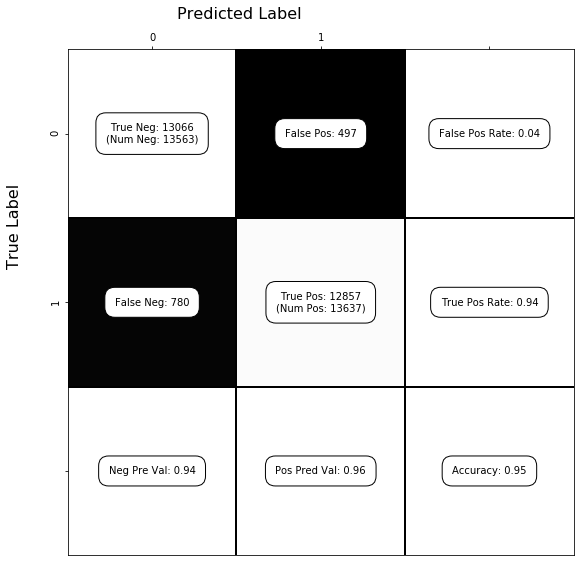

In [39]:
from display_confusion_matrix import display_confusion_matrix
from sklearn.metrics import confusion_matrix
display_confusion_matrix(confusion_matrix(sentiment_test.argmax(axis=1), sentiment_pred_class))

# Naive Bayes

Let's see how a simple Naive Bayes model does on this sentiment classification task.

In [40]:
import re
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [41]:
reviews_labeled.shape

(136002, 2)

In [42]:
reviews_labeled.tail()

,is_positive,text
135997,0,The food is ok but the service is questionnabl...
135998,1,"Delicious - all of the pasties are great, and ..."
135999,1,Oh my god the horchata latte is amazeballs!! A...
136000,0,Walked out bfore ordering!\nWent for a quiet d...
136001,0,Went last night for dinner with our son. Took ...


In [43]:
def tokenizer_nb(doc):
    """doc is a single string - this function returns a list of word tokens 
    in the input string with all punctuations removed and words lower-cased"""
    tokens = doc.split(' ')
    tokens = [re.sub('[^A-Za-z0-9]+', '', tok) for tok in tokens]
    tokens = [tok.lower() for tok in tokens if len(tok) > 0]
    return tokens

In [48]:
text_train = train.text.values.tolist()
sentiment_train = train.is_positive.values

In [49]:
text_test = test.text.values.tolist()
sentiment_test = test.is_positive.values

In [50]:
# borrowed the helper function below from the NLP labs
def text_classifcation(clf: Pipeline, train_data, test_data, train_target, test_target):
    "Helper function wrapping the Pipeline."
    clf.fit(train_data, train_target) 
    predicted = clf.predict(test_data)
    accuracy = np.mean(predicted==test_target)
    print(f"The accuracy on the test data is {accuracy:.2%}")

In [51]:
vocab_size = 10000    # the maximum size of our vocabulary
clf = Pipeline([('vect', CountVectorizer(tokenizer=tokenizer_nb, max_features=vocab_size)),
                ('clf', MultinomialNB())])

text_classifcation(clf, text_train, text_test, sentiment_train, sentiment_test)

The accuracy on the test data is 94.56%


In [52]:
def text_classifcation_predictions(clf: Pipeline, train_data, test_data, train_target, test_target):
    "Helper function wrapping the Pipeline."
    clf.fit(train_data, train_target) 
    predicted = clf.predict(test_data)
    accuracy = np.mean(predicted==test_target)
    print(f"The accuracy on the test data is {accuracy:.2%}")
    return predicted

In [53]:
sentiment_test_predictions = text_classifcation_predictions(clf, text_train, text_test, sentiment_train, sentiment_test)
tn, fp, fn, tp = confusion_matrix(sentiment_test, sentiment_test_predictions).ravel()
print(f'False Negatives: {fn}')
print(f'False Positives: {fp}')

The accuracy on the test data is 94.56%
False Negatives: 718
False Positives: 762


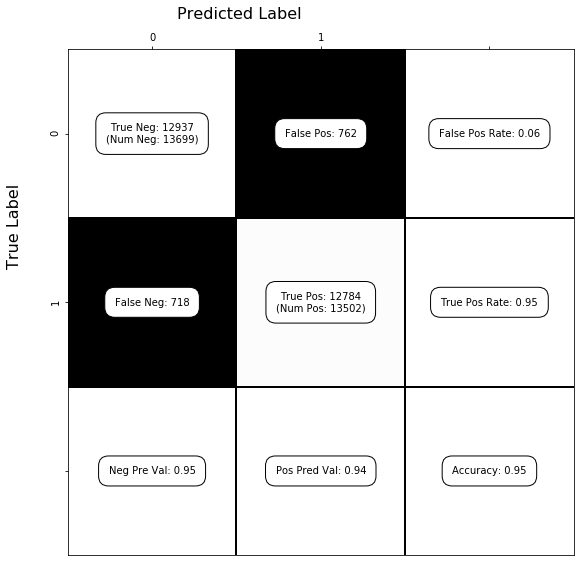

In [54]:
display_confusion_matrix(confusion_matrix(sentiment_test, sentiment_test_predictions))

# Note

The simple Naive Bayes model performed nearly as well as the LSTM model.  In practice, in a situation like this, it would make sense to use the Naive Bayes model, unless very marginal improvements in accuracy are somehow important.  Also, the LSTM model can quite likely be tuned further to extract further improvements out of it.